# Autoencoders & RNNs

The file is broken up as follows:  

1. [Question 1: Masked Autoencoder, Revisited (three points total)](#1)
2. [Question 2: A Simple Sequence Task (three points total)](#2)  
3. [Question 3: Sequence-to-Sequence Translation (three points total)](#3)
4. [Question 4: Short Response (two points total)](#4)  
5. [Question 5: Deep Reinforcement learning (four points total)](#5)


## Setup

If you do not have access to a CUDA-compatible NVIDIA GPU, it is recommended that you run this notebook in [Google Colab](https://colab.research.google.com/). There, you will have the option to enable GPU acceleration with `Runtime` >> `Change runtime type` >> `Hardware accelerator` >> `GPU` >> `Save`. Note that you may have to re-connect or restart the notebook after changing runtime types.

In [1]:
# helper code from the course repository
!git clone https://github.com/interactiveaudiolab/course-deep-learning.git
# install common pacakges used for deep learning
!cd course-deep-learning/ && pip install -r requirements.txt

fatal: destination path 'course-deep-learning' already exists and is not an empty directory.
  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/c0/bc/77635c657a3668cf652806210b8662e1aff84b818a55ba88257abf6637a8/numpy-1.24.4-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Using cached numpy-1.24.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-macosx_11_0_arm64.whl (13.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.3
    Uninstalling numpy-2.2.3:
      Successfully uninstalled numpy-2.2.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
moviepy 2.1.2 requires numpy>=1.25.

In [2]:
%matplotlib inline
%cd course-deep-learning/

import datetime
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from matplotlib.animation import FuncAnimation
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm
import torchvision

from utils.gan import *

/Users/luhsin/Downloads/course-deep-learning


----
## <a name="1">Question 1: Masked Autoencoder, Revisited (3 points total)</a>


### __1.1__ A Bigger Mask (one point)

Train the MLP-based inpainting autoencoder from [notebook 7](https://github.com/interactiveaudiolab/course-deep-learning/blob/main/notebooks/notebook_7_autoencoder.ipynb) but this time, re-write `apply_mask()` (and your training code) to __deterministically zero-out the _left half_ of every input image. Train for 30 epochs, and place a plot of your reconstruction loss vs. epochs below.__ 

*Hint: make sure that you apply the mask to a copy of each input rather than destructively editing the input itself, as the original input still has to serve as a target!*

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR LOSS PLOT HERE)</div>
</center>


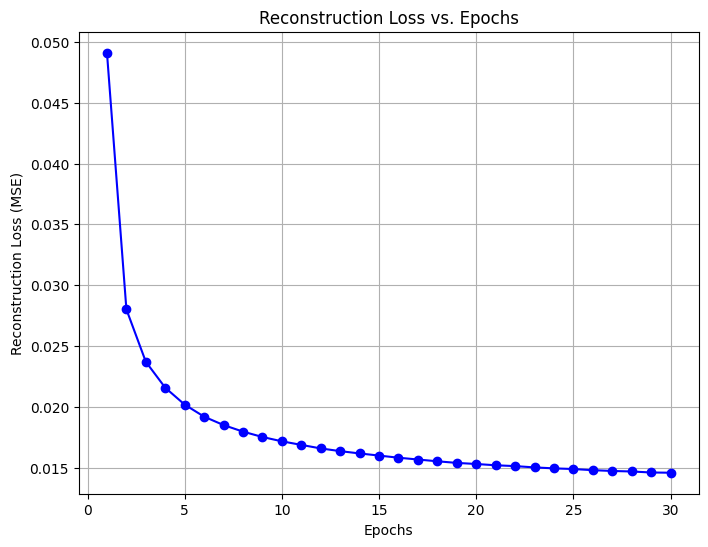

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class MLPEncoder(torch.nn.Module):
    
    def __init__(self, 
                 number_of_hidden_layers: int, 
                 input_size: int, 
                 hidden_size: int, 
                 latent_size: int,
                 activation: torch.nn.Module):
        """Construct a simple MLP encoder"""
        
        super().__init__()
        
        assert number_of_hidden_layers >= 0, "Encoder number_of_hidden_layers must be at least 0"
        
        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [latent_size]  # final output should be latent size
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))
            
            if i < number_of_hidden_layers:
                layers.append(activation)

        self.net = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor):
        return self.net(x)


class MLPDecoder(torch.nn.Module):
    
    def __init__(self, 
                 number_of_hidden_layers: int, 
                 latent_size: int, 
                 hidden_size: int, 
                 input_size: int,
                 activation: torch.nn.Module):
        """Construct a simple MLP decoder"""
        
        super().__init__()
        
        assert number_of_hidden_layers >= 0, "Decoder number_of_hidden_layers must be at least 0"
        
        dims_in = [latent_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [input_size]  # final output is an image
        
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))
            
            if i < number_of_hidden_layers:
                layers.append(activation)
        
        # apply Tanh after final layer to bound pixels to range [-1, 1]
        layers.append(torch.nn.Sigmoid())
        
        self.net = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor):
        return self.net(x)


class MLPAutoencoder(torch.nn.Module):
                          
    def __init__(self, 
                 number_of_hidden_layers: int, 
                 input_size: int, 
                 hidden_size: int, 
                 latent_size: int,
                 activation_encoder: torch.nn.Module = torch.nn.ReLU(),
                 activation_decoder: torch.nn.Module = torch.nn.LeakyReLU(0.2)
                ):
        """Construct a simple MLP autoencoder
        
        number_of_hidden_layers: An int. Must be >=0. Defines the number of
                hidden layers for both the encoder E and decoder D 
        latent_size:  An int. Defines the size of the latent representation produced by
                      the encoder.
        hidden_size: An int. The size of each hidden layer for the encoder E and
                     the decoder D.
        input_size: An int. Determines the size of the input and output images
        activation_encoder: A torch.nn.Module defining the activation function in every 
                            hidden layer of the encoder.
        activation_decoder: A torch.nn.Module defining the activation function in every 
                            hidden layer of the decoder.
        """
        super().__init__()
                          
        self.encoder = MLPEncoder(
            number_of_hidden_layers=number_of_hidden_layers, 
            input_size=input_size, 
            hidden_size=hidden_size, 
            latent_size=latent_size,
            activation=activation_encoder
        )
        
        self.decoder = MLPDecoder(
            number_of_hidden_layers=number_of_hidden_layers, 
            input_size=input_size, 
            hidden_size=hidden_size,
            latent_size=latent_size,
            activation=activation_decoder
        )    
        
    def encode(self, x: torch.Tensor):
        return self.encoder(x)
        
    def decode(self, x: torch.Tensor):
        return self.decoder(x)
        
    def forward(self, x: torch.Tensor):
        return(self.decode(self.encode(x)))
    

Epoch [1/30], Loss: 0.0491
Epoch [2/30], Loss: 0.0280
Epoch [3/30], Loss: 0.0237
Epoch [4/30], Loss: 0.0216
Epoch [5/30], Loss: 0.0202
Epoch [6/30], Loss: 0.0192
Epoch [7/30], Loss: 0.0185
Epoch [8/30], Loss: 0.0180
Epoch [9/30], Loss: 0.0175
Epoch [10/30], Loss: 0.0172
Epoch [11/30], Loss: 0.0169
Epoch [12/30], Loss: 0.0166
Epoch [13/30], Loss: 0.0164
Epoch [14/30], Loss: 0.0162
Epoch [15/30], Loss: 0.0160
Epoch [16/30], Loss: 0.0158
Epoch [17/30], Loss: 0.0157
Epoch [18/30], Loss: 0.0155
Epoch [19/30], Loss: 0.0154
Epoch [20/30], Loss: 0.0153
Epoch [21/30], Loss: 0.0152
Epoch [22/30], Loss: 0.0151
Epoch [23/30], Loss: 0.0150
Epoch [24/30], Loss: 0.0149
Epoch [25/30], Loss: 0.0149
Epoch [26/30], Loss: 0.0148
Epoch [27/30], Loss: 0.0147
Epoch [28/30], Loss: 0.0147
Epoch [29/30], Loss: 0.0146
Epoch [30/30], Loss: 0.0146


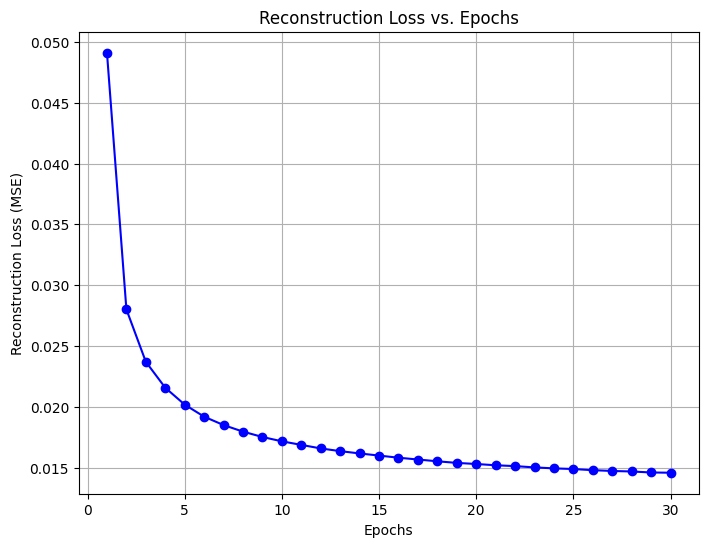

In [ ]:
# Function to deterministically mask the left half of an image
def apply_mask(x):
    x_masked = x.clone() # create a copy of the input :)
    x_masked[:, :, :, :x.shape[3] // 2] = 0  # Zero out left half
    return x_masked

# Initialize model, loss, and optimizer
model = MLPAutoencoder(number_of_hidden_layers=2, input_size=784, hidden_size=128, latent_size=32).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model for 30 epochs
num_epochs = 30
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_idx, (x_real, _) in enumerate(train_loader):
        x_real = x_real.to(device)
        n_batch = x_real.shape[0]
        x_real = x_real.view(n_batch, -1) # Flatten 
        
        x_masked = apply_mask(x_real.view(n_batch, 1, 28, 28))
        x_masked = x_masked.view(n_batch, -1)  # Flatten 
        
        optimizer.zero_grad()
        x_reconstructed = model(x_masked) 
        loss = criterion(x_reconstructed, x_real)  # Compare to original image
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Plot reconstruction loss vs. epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), losses, marker='o', linestyle='-', color='b')
plt.xlabel("Epochs")
plt.ylabel("Reconstruction Loss (MSE)")
plt.title("Reconstruction Loss vs. Epochs")
plt.grid()
plt.show()


### __1.2__ Reconstruction (one point)

The code below provides a hard-coded example image of a "3." __Pass this image through your new inpainting autoencoder and include the reconstructed image below.  Does your autoencoder faithfully reconstruct the input (i.e. produce a similar-looking image of the same class)? If not, briefly explain why you think the reconstruction looks the way it does.__

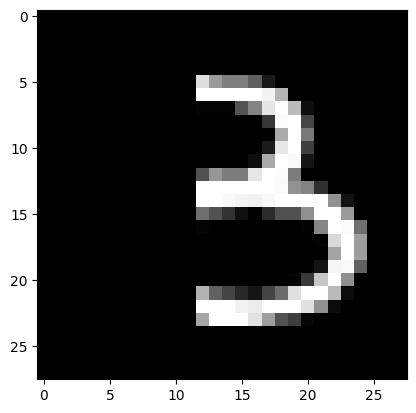

In [ ]:
x = torch.as_tensor(
    [[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8667, 0.6000, 0.4941, 0.4941, 0.3765, 0.0941, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.9490, 0.7059, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0157, 0.0157, 0.0157, 0.3255, 0.5059, 0.8941, 0.9922, 0.7294, 0.0549, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2118, 0.9765, 0.9961, 0.2706, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6627, 0.9961, 0.4706, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1020, 0.8980, 0.9961, 0.2471, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0549, 0.6588, 0.9961, 0.9725, 0.0863, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3216, 0.5843, 0.4863, 0.4863, 0.8980, 0.9961, 0.9804, 0.4863, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.9765, 0.5647, 0.5059, 0.1882, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9961, 0.9961, 0.9725, 0.9490, 0.9373, 0.9686, 0.9961, 0.9961, 0.9961, 0.9922, 0.5647, 0.0706, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4314, 0.3176, 0.2000, 0.0627, 0.0000, 0.1765, 0.3176, 0.3176, 0.5608, 0.9961, 0.9961, 0.6000, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0157, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0118, 0.5176, 0.9961, 0.9843, 0.4353, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0118, 0.8471, 0.9961, 0.6157, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6392, 0.9961, 0.6157, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0745, 0.9608, 0.9725, 0.3843, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0157, 0.2196, 0.7765, 0.9961, 0.5608, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6980, 0.3804, 0.2667, 0.1529, 0.0824, 0.2667, 0.4235, 0.8745, 0.9961, 0.9961, 0.7255, 0.0392, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9961, 0.9961, 0.9961, 0.9451, 0.9176, 0.9961, 0.9961, 0.9961, 0.8745, 0.5608, 0.0392, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6471, 0.9961, 0.9961, 0.9961, 0.8784, 0.6157, 0.3216, 0.2431, 0.0235, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
      [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]])

plt.imshow(x.squeeze(), cmap='gray')
plt.show()

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR RECONSTRUCTED IMAGE HERE)</div>
</center>


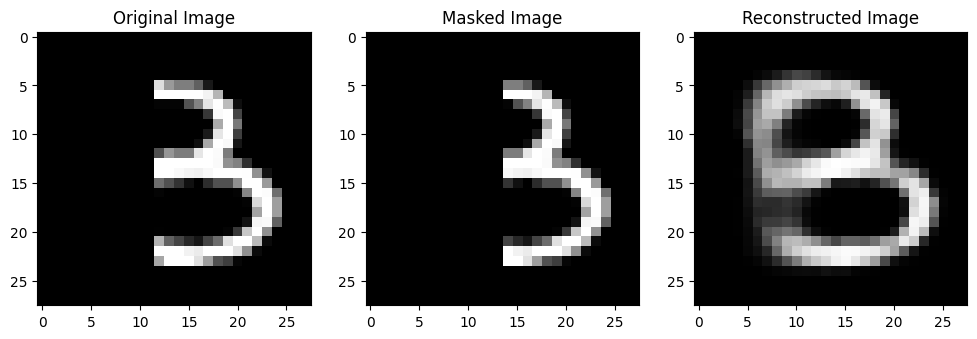

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR EXPLANATION HERE)</div>
</center>


- The reconstructed image of 3 looks like an "8"-shaped figure.
- This makes sense because, during training, we ***give the machine with a masked input of the image, in which case 3 and 8 appear the same after masking***. Since we are using MSE, from the machine's perspective, guessing 8 would result in a near-perfect reconstruction and would not be too far off when the true 𝑥 x is 3.

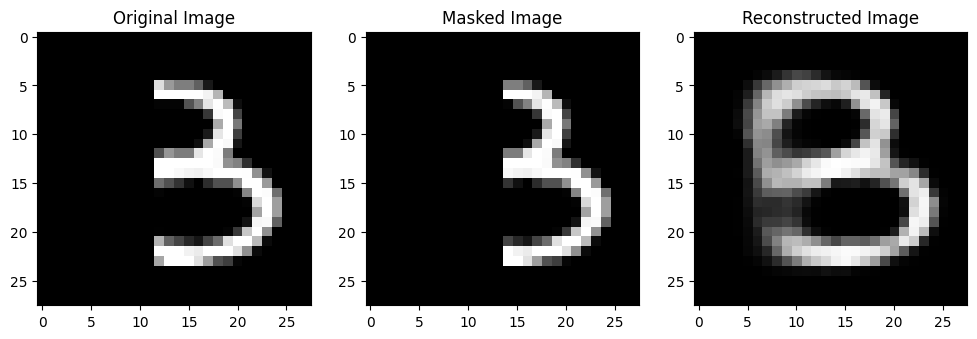

In [17]:
x = x.to(device)
x_masked = apply_mask(x.unsqueeze(0)).view(1, -1)  # Apply mask and flatten
x_reconstructed = model(x_masked).view(1, 28, 28).detach().cpu()

# Plot original, masked, and reconstructed images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(x.squeeze().cpu(), cmap='gray')
axes[0].set_title("Original Image")
axes[1].imshow(x_masked.view(28, 28).cpu(), cmap='gray')
axes[1].set_title("Masked Image")
axes[2].imshow(x_reconstructed.squeeze(), cmap='gray')
axes[2].set_title("Reconstructed Image")
plt.show()


### __1.3__ Augmentation (one point)

In [notebook 4](https://github.com/interactiveaudiolab/course-deep-learning/blob/main/notebooks/notebook_4_augmentation_logging.ipynb), we learned how to apply random augmentations to image data. __Create a `RandomAffine` transform that applies:__
* __Rotations between -10 and 10 degrees__
* __Horizontal and vertical translations of at most 0.2__
* __Shear between -5 and 5 degrees__

__Using this randomized transform, create three augmented versions of the hard-coded image above. For each augmented version obtain a reconstruction by passing it to your inpainting autoencoder. Include the three augmented images and three corresponding reconstructions below.__

__Finally, answer the following question: does your autoencoder reconstruct the augmented images correctly and consistently? If not, explain why you think this may be the case.__

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR AUGMENTED AND RECONSTRUCTED IMAGES HERE)</div>
</center>


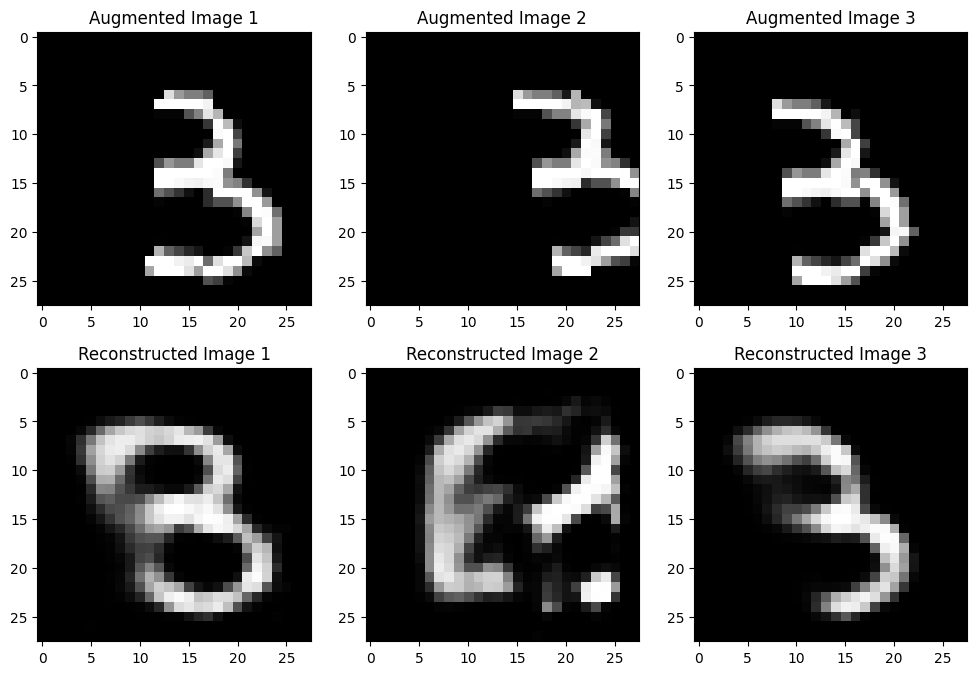

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR EXPLANATION HERE)</div>
</center>

- I would say, in general, the autoencoder cannot reconstruct the image correctly and consistently (though sometimes the reconstruction looks fine).
- The reason could be that the autoencoder is only trained on normal MNIST data, not the augmented ones. If it has not seen rotated, translated, or sheared digits before, it may fail to reconstruct the image.
- A better way would be to train on augmented data so that the model can handle transformations.


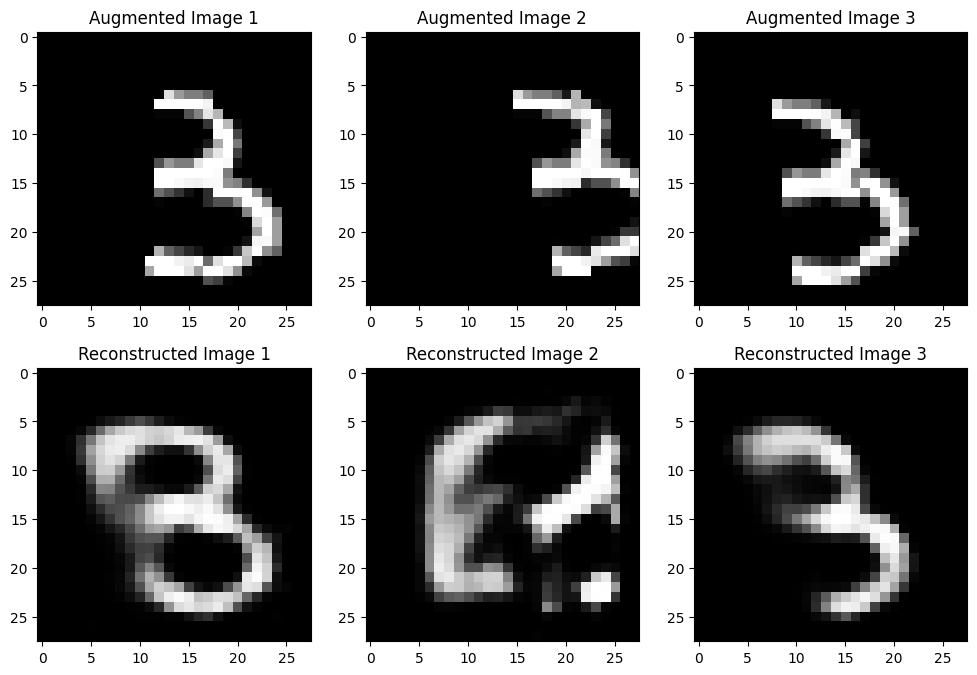

In [ ]:
# Define RandomAffine transform
random_affine = transforms.RandomAffine(
    degrees=10,  # Rotation between -10 and 10 degrees
    translate=(0.2, 0.2),  # Horizontal and vertical translations up to 20%
    shear=5  # Shear between -5 and 5 degrees
)

# Apply the transformation to create three augmented versions of the image
augmented_images = [random_affine(x) for _ in range(3)]

# Obtain reconstructions for each augmented image
reconstructed_images = [
    model(apply_mask(aug.view(1, 1, 28, 28)).view(1, -1).to(device)).view(1, 28, 28).detach().cpu()
    for aug in augmented_images
]

# Plot augmented and reconstructed images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i in range(3):
    axes[0, i].imshow(augmented_images[i].squeeze(), cmap='gray')
    axes[0, i].set_title(f"Augmented Image {i+1}")
    axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
    axes[1, i].set_title(f"Reconstructed Image {i+1}")
plt.show()


----
## <a name="2">Question 2: A Simple Sequence Task (4 points total)</a>

In this question, we'll explore the differences between standard recurrent neural networks (RNNs) and long short-term memory networks (LSTMs) using a simple addition task akin to the one used in the [original LSTM paper](https://www.researchgate.net/publication/13853244_Long_Short-term_Memory).

### __2.1__ Theoretical Comparison (1 points)

__Explain the argument for why we would expect an [LSTM](https://www.researchgate.net/publication/13853244_Long_Short-term_Memory) to outperform a standard RNN on problems that involve processing long sequences.__

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR ANSWER HERE)</div>
</center>


- On tasks involving long sequences, we expect LSTMs to outperform RNNs because:
    - In an RNN, the recurrent connections use the same weight matrix at each time step. If the eigenvalues of the weight matrix are small, the gradients will shrink exponentially during backpropagation, leading to the vanishing gradient problem. Conversely, if the eigenvalues are large, the gradients will explode, causing the exploding gradient problem.
    - LSTMs introduce a gated mechanism (input, forget, and output gates) to control the flow of information:
        - Cell state: allows information to persist without being transformed.
        - Forget gate: alllows the model to discard information no longer needed.
        - Input gate: controls how much new information is stored in cell.
        - Output gate: controls how much cell state should be carry onto the next time step.
    - In summary, the LSTM cell state enables information to be carried forward mostly unchanged, allowing important information from earlier times to be preserved over long sequences.    
    - In contrast, RNNs rely on backpropagated gradients through repeated multiplications, making it difficult to retain relevant information over long periods..


### __2.2__ Empirical Comparison (2 points)

__Use the code provided below to compare the performance of a standard RNN to an LSTM on the task defined by the `Add2DigitsDataset`. Do this for three different lengths of sequence (5, 10, and 30). For all experiments, use a hidden size of 128 and 2 layers. Keep your network architecture the same, except for the substitution of the LSTM for an RNN. Provide the following graphs for each sequence length:__

  1. __Loss as a function of the number of training steps__  
  2. __Training accuracy & validation accuracy as a function of the number of training steps.__

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR LOSS PLOTS HERE) AND (YOUR ACCURACY PLOTS HERE)</div>
</center>


***LENGTH 5 - RNN and LSTM***

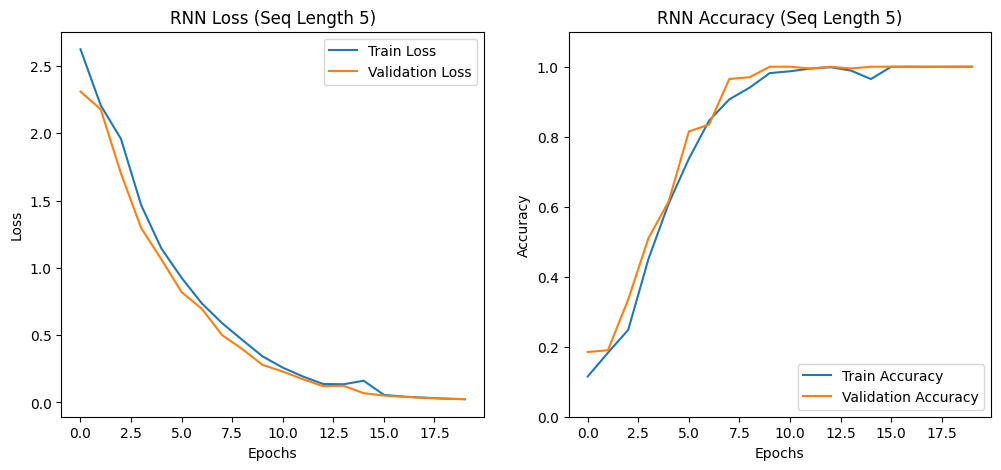
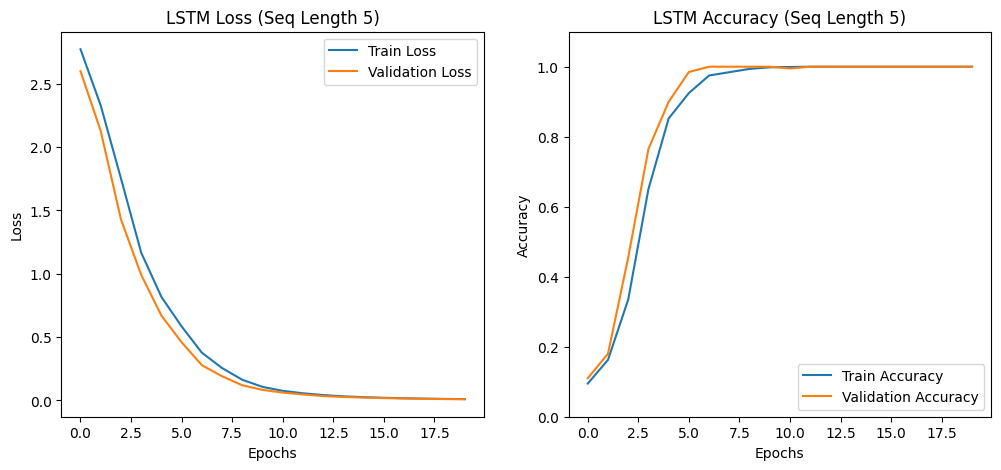

***LENGTH 10 - RNN and LSTM***

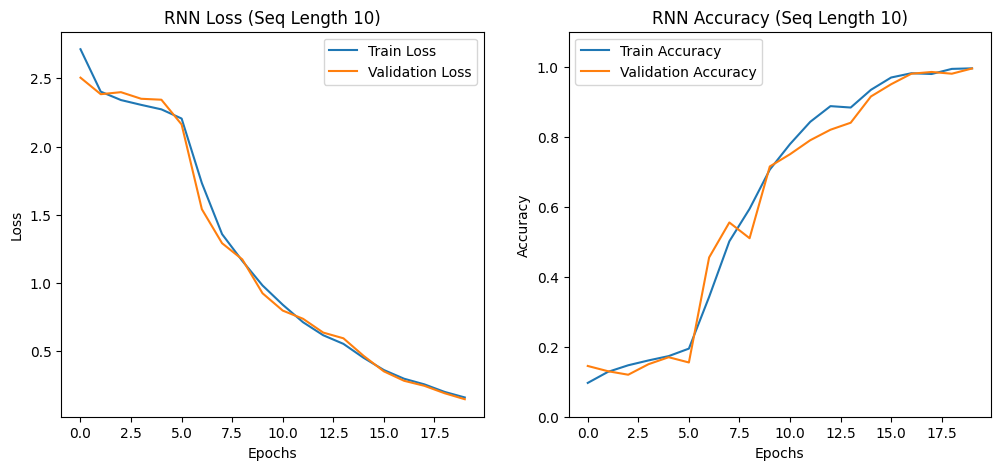
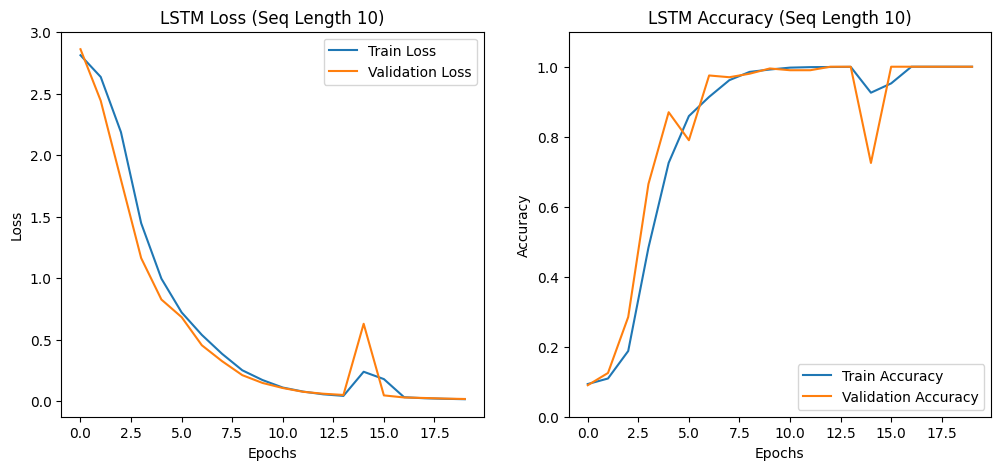

***LENGTH 5 - RNN and LSTM***

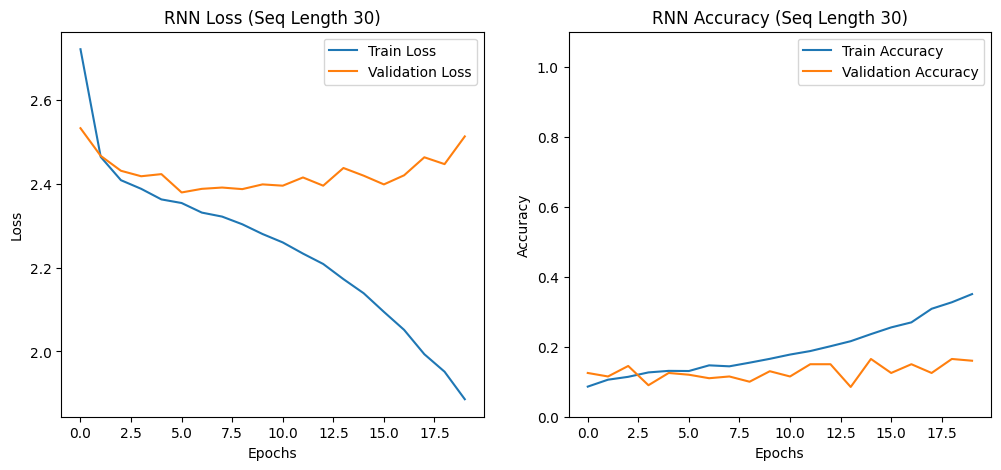
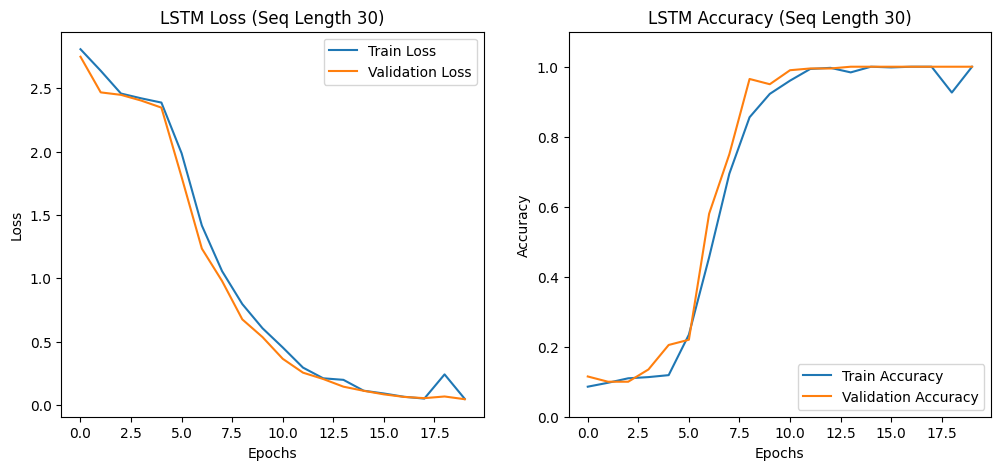

The following utility code is provided to help with the question. Note that the addition task is formulated as a _classification_ rather than _regression_ problem: because the operands are digits, their sum must be a positive integer in [0, 18], allowing us to output a vector of "class scores" over these potential values.

In [43]:
def MakeItHot(data, num_tokens):
  """ Make the one hot encoding of the input."""
  i_size, j_size = data.shape
  one_hot_data = torch.zeros(i_size, j_size, num_tokens)
  for i in range(0,i_size):
    for j in range(0,j_size):
      one_hot_data[i,j,data[i,j]] = 1
  return one_hot_data
  
def KeepItCool(data):
  """Just use the data as-is...but with a new dimension added"""
  return torch.unsqueeze(data,2)


class Add2DigitsDataset(torch.utils.data.Dataset):
    """Add2DigitsDataset"""

    def __init__(self, num_examples=3, seq_length=10):
        """Create a set of examples, where each example is a sequence of single 
        positive digits (0 through 9) interspersed with 1 instance of a negative
        one. The game is to sum the final digit in the sequence with the 
        digit after the -1. The correct label y for the sequence x is the sum of 
        these two digits. Here are 3 examples. 

        x = [1, -1, 3, 7, 8, 9] y = 12
        x = [9, 1, 2, 4, -1, 7, 2, 3, 1, 0] y = 7
        x = [9, -1, 9, 2 , 1, 3, 0, 5, 6, 4, 7, 8, 5, 1] y = 10

        
        PARAMETERS
        ----------
        num_examples    A non-negative integer determining how much data we'll generate
        seq_length      A non-negative integer saying how long the sequences all are.
 
        EXAMPLE USE
        -----------
        dataset = Add2DigitsDataset(num_examples = 100, seq_length = 9)
        data, one_hot_data, labels  = dataset[:]
        print(f'Train instances: one_hot_data (shape {one_hot_data.shape}), labels (shape {labels.shape})')
        loader =  torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
        """

        assert seq_length >=3, "Seq_length must be a minimum of 3"
        self.seq_length = seq_length
        self.num_tokens = 11

        # make random sequences of integers of the right length
        data = torch.randint(10, (num_examples, seq_length))
        # the labels will go here...
        label = torch.ones(num_examples,1)

        # Now insert our special tokens 
        for x in range(0, num_examples):
          # figure out where to place our special token 
          a_idx = torch.randint(0, seq_length-2, (1,1)).squeeze()
          # insert the special_tokens 
          data[x,[a_idx]] = -1
          # create the label by summing the digit after the special -1 token
          # with the final digit in the sequence
          label[x] = data[x,a_idx+1]+data[x,-1]
        
        # OK. Store data for later.
        self.data = KeepItCool(data)
        self.one_hot_data = MakeItHot(data, num_tokens=self.num_tokens)
        self.label = label.squeeze().long()
        self.lengths = self.seq_length * torch.ones_like(self.label)
        self.lengths = self.lengths.squeeze().long().tolist()

    def __len__(self):
      return len(self.label)

    def __getitem__(self, idx):
      return self.data[idx], self.one_hot_data[idx], self.label[idx] #, self.lengths[idx]


  
# Make sure our dataset looks correct by looking at a few examples...
dataset = Add2DigitsDataset(num_examples=100,seq_length=5)
data, one_hot_data, labels = dataset[:3]
# inputs have shape (B, MAX_L, V) where MAX_L is largest length in batch
print(f'data.shape: {data.shape}, one_hot_data.shape: {one_hot_data.shape}, labels.shape: {labels.shape}')
print(f'data: {data}, one_hot_data: {one_hot_data}, labels: {labels}')

data.shape: torch.Size([3, 5, 1]), one_hot_data.shape: torch.Size([3, 5, 11]), labels.shape: torch.Size([3])
data: tensor([[[ 5],
         [-1],
         [ 4],
         [ 8],
         [ 4]],

        [[-1],
         [ 7],
         [ 7],
         [ 6],
         [ 9]],

        [[ 9],
         [-1],
         [ 5],
         [ 9],
         [ 8]]]), one_hot_data: tensor([[[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 

In [44]:
class MyRNN(nn.Module):
  """ A simple RNN that that lets you select architectural features when creating
  a new instance """

  def __init__(self, 
               input_size: int, 
               hidden_size: int, 
               output_size: int,
               num_layers: int = 1,
               use_LSTM: bool = True):

    super().__init__()

    if use_LSTM:  
      self.rnn = nn.LSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True)
    else: 
      self.rnn = nn.RNN(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True)

    self.out_proj = nn.Linear(hidden_size, output_size)
    

  def forward(self, x: torch.Tensor):

    # require batched inputs: (B, MAX_L, V)
    # Here b = the batch size, l = sequence length , v = input token size (i.e. 
    # the number of positiions in a one-hot-encoding array)
    assert x.ndim == 3
    b, l, v = x.shape

    # built-in PyTorch layer handles loop along sequence dimension,
    # including passing hidden state back each time step. It also 
    # handles creating a new initial state for each batch!
    output, hidden = self.rnn(x)

    # for each item in batch, take final output state 
    output = output[:,-1,:]
    
    # apply final linear layer to get predictions
    output = self.out_proj(output)

    return output


# declare the model and try out th untrained model on a sequence
model = MyRNN(
    input_size=11,
    hidden_size= 128,
    output_size=19, # allow outputs in range [0, 18]
    num_layers=2,  
    use_LSTM=False)

# you should use `num_token` = 11: ten tokens for the digits, plus the special -1 token
input =  MakeItHot(torch.tensor([[1,2,3,1,5,6,-1,9,3,4,5,0]]), num_tokens=11)
prediction = model(input)
print('My prediction is ', torch.argmax(prediction))

My prediction is  tensor(10)


In [105]:
#Your experiment code goes here
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        
        for data, one_hot_data, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(one_hot_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
            total += labels.size(0)
        
        train_losses.append(train_loss / len(train_loader))
        train_accs.append(correct / total)
        
        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for data, one_hot_data, labels in val_loader:
                outputs = model(one_hot_data)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
                total += labels.size(0)
        
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(correct / total)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')
    
    return train_losses, val_losses, train_accs, val_accs

Training for sequence length: 5
Epoch 1/20, Train Loss: 2.6234, Val Loss: 2.3090, Train Acc: 0.1150, Val Acc: 0.1850
Epoch 2/20, Train Loss: 2.2073, Val Loss: 2.1771, Train Acc: 0.1830, Val Acc: 0.1900
Epoch 3/20, Train Loss: 1.9580, Val Loss: 1.7010, Train Acc: 0.2482, Val Acc: 0.3350
Epoch 4/20, Train Loss: 1.4655, Val Loss: 1.2957, Train Acc: 0.4506, Val Acc: 0.5100
Epoch 5/20, Train Loss: 1.1436, Val Loss: 1.0624, Train Acc: 0.6092, Val Acc: 0.6150
Epoch 6/20, Train Loss: 0.9255, Val Loss: 0.8198, Train Acc: 0.7370, Val Acc: 0.8150
Epoch 7/20, Train Loss: 0.7359, Val Loss: 0.6955, Train Acc: 0.8462, Val Acc: 0.8350
Epoch 8/20, Train Loss: 0.5896, Val Loss: 0.5008, Train Acc: 0.9068, Val Acc: 0.9650
Epoch 9/20, Train Loss: 0.4648, Val Loss: 0.3969, Train Acc: 0.9402, Val Acc: 0.9700
Epoch 10/20, Train Loss: 0.3428, Val Loss: 0.2798, Train Acc: 0.9818, Val Acc: 1.0000
Epoch 11/20, Train Loss: 0.2591, Val Loss: 0.2294, Train Acc: 0.9870, Val Acc: 1.0000
Epoch 12/20, Train Loss: 0.1930

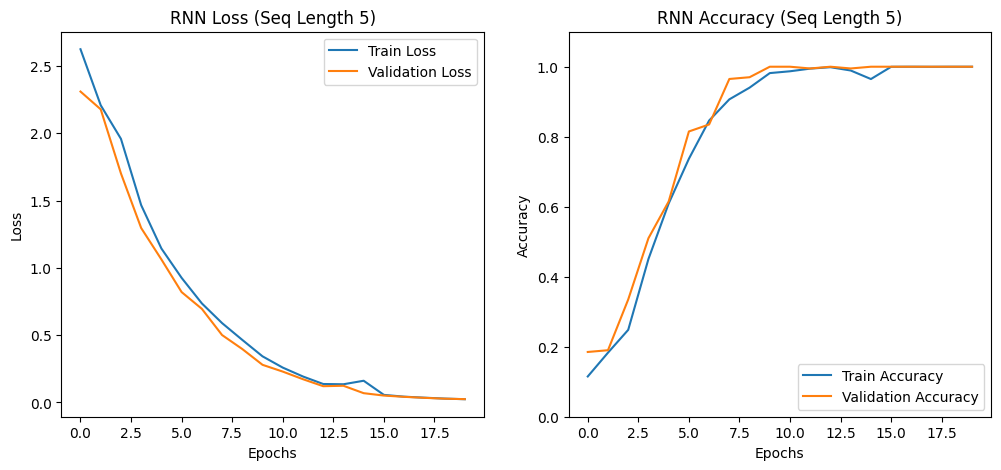

Epoch 1/20, Train Loss: 2.7734, Val Loss: 2.6001, Train Acc: 0.0948, Val Acc: 0.1100
Epoch 2/20, Train Loss: 2.3294, Val Loss: 2.1274, Train Acc: 0.1624, Val Acc: 0.1800
Epoch 3/20, Train Loss: 1.7534, Val Loss: 1.4300, Train Acc: 0.3348, Val Acc: 0.4550
Epoch 4/20, Train Loss: 1.1673, Val Loss: 0.9922, Train Acc: 0.6504, Val Acc: 0.7650
Epoch 5/20, Train Loss: 0.8178, Val Loss: 0.6701, Train Acc: 0.8522, Val Acc: 0.9000
Epoch 6/20, Train Loss: 0.5839, Val Loss: 0.4589, Train Acc: 0.9248, Val Acc: 0.9850
Epoch 7/20, Train Loss: 0.3769, Val Loss: 0.2784, Train Acc: 0.9750, Val Acc: 1.0000
Epoch 8/20, Train Loss: 0.2554, Val Loss: 0.1909, Train Acc: 0.9844, Val Acc: 1.0000
Epoch 9/20, Train Loss: 0.1631, Val Loss: 0.1195, Train Acc: 0.9938, Val Acc: 1.0000
Epoch 10/20, Train Loss: 0.1068, Val Loss: 0.0832, Train Acc: 0.9984, Val Acc: 1.0000
Epoch 11/20, Train Loss: 0.0758, Val Loss: 0.0620, Train Acc: 0.9992, Val Acc: 0.9950
Epoch 12/20, Train Loss: 0.0564, Val Loss: 0.0470, Train Acc: 1

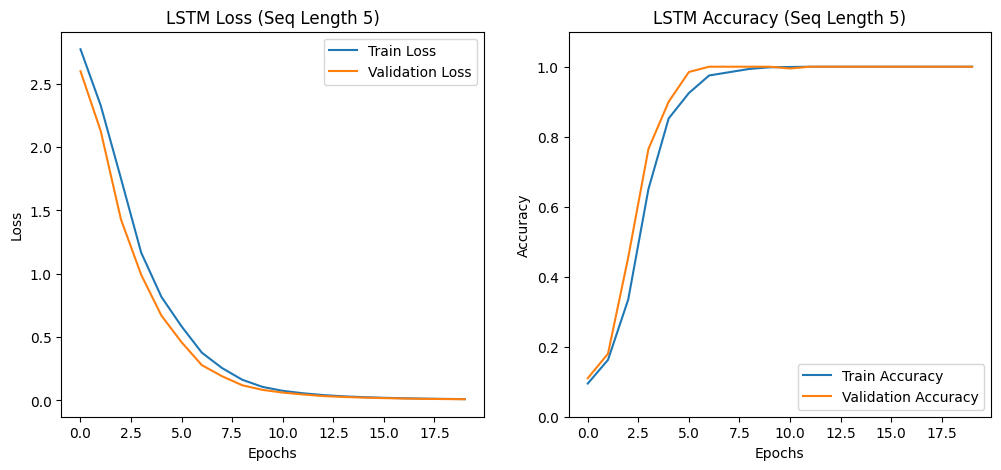

Training for sequence length: 10
Epoch 1/20, Train Loss: 2.7139, Val Loss: 2.5053, Train Acc: 0.0966, Val Acc: 0.1450
Epoch 2/20, Train Loss: 2.4029, Val Loss: 2.3840, Train Acc: 0.1282, Val Acc: 0.1300
Epoch 3/20, Train Loss: 2.3411, Val Loss: 2.3988, Train Acc: 0.1470, Val Acc: 0.1200
Epoch 4/20, Train Loss: 2.3057, Val Loss: 2.3504, Train Acc: 0.1608, Val Acc: 0.1500
Epoch 5/20, Train Loss: 2.2727, Val Loss: 2.3435, Train Acc: 0.1732, Val Acc: 0.1700
Epoch 6/20, Train Loss: 2.2053, Val Loss: 2.1618, Train Acc: 0.1946, Val Acc: 0.1550
Epoch 7/20, Train Loss: 1.7320, Val Loss: 1.5403, Train Acc: 0.3424, Val Acc: 0.4550
Epoch 8/20, Train Loss: 1.3573, Val Loss: 1.2906, Train Acc: 0.5012, Val Acc: 0.5550
Epoch 9/20, Train Loss: 1.1610, Val Loss: 1.1721, Train Acc: 0.5940, Val Acc: 0.5100
Epoch 10/20, Train Loss: 0.9808, Val Loss: 0.9234, Train Acc: 0.7060, Val Acc: 0.7150
Epoch 11/20, Train Loss: 0.8393, Val Loss: 0.7964, Train Acc: 0.7790, Val Acc: 0.7500
Epoch 12/20, Train Loss: 0.711

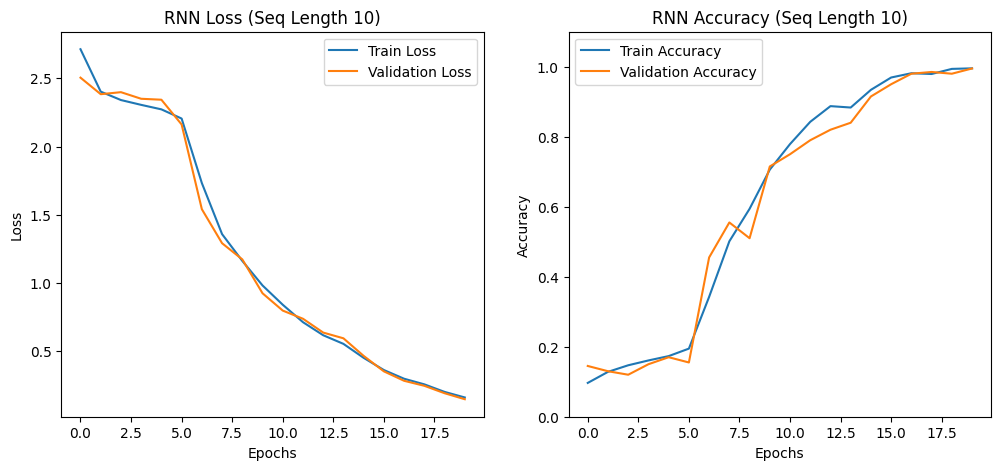

Epoch 1/20, Train Loss: 2.8120, Val Loss: 2.8608, Train Acc: 0.0934, Val Acc: 0.0900
Epoch 2/20, Train Loss: 2.6356, Val Loss: 2.4423, Train Acc: 0.1092, Val Acc: 0.1250
Epoch 3/20, Train Loss: 2.1872, Val Loss: 1.8009, Train Acc: 0.1878, Val Acc: 0.2850
Epoch 4/20, Train Loss: 1.4473, Val Loss: 1.1637, Train Acc: 0.4830, Val Acc: 0.6650
Epoch 5/20, Train Loss: 0.9969, Val Loss: 0.8272, Train Acc: 0.7254, Val Acc: 0.8700
Epoch 6/20, Train Loss: 0.7226, Val Loss: 0.6839, Train Acc: 0.8590, Val Acc: 0.7900
Epoch 7/20, Train Loss: 0.5397, Val Loss: 0.4555, Train Acc: 0.9138, Val Acc: 0.9750
Epoch 8/20, Train Loss: 0.3859, Val Loss: 0.3262, Train Acc: 0.9616, Val Acc: 0.9700
Epoch 9/20, Train Loss: 0.2522, Val Loss: 0.2127, Train Acc: 0.9852, Val Acc: 0.9800
Epoch 10/20, Train Loss: 0.1729, Val Loss: 0.1493, Train Acc: 0.9920, Val Acc: 0.9950
Epoch 11/20, Train Loss: 0.1120, Val Loss: 0.1082, Train Acc: 0.9974, Val Acc: 0.9900
Epoch 12/20, Train Loss: 0.0794, Val Loss: 0.0776, Train Acc: 0

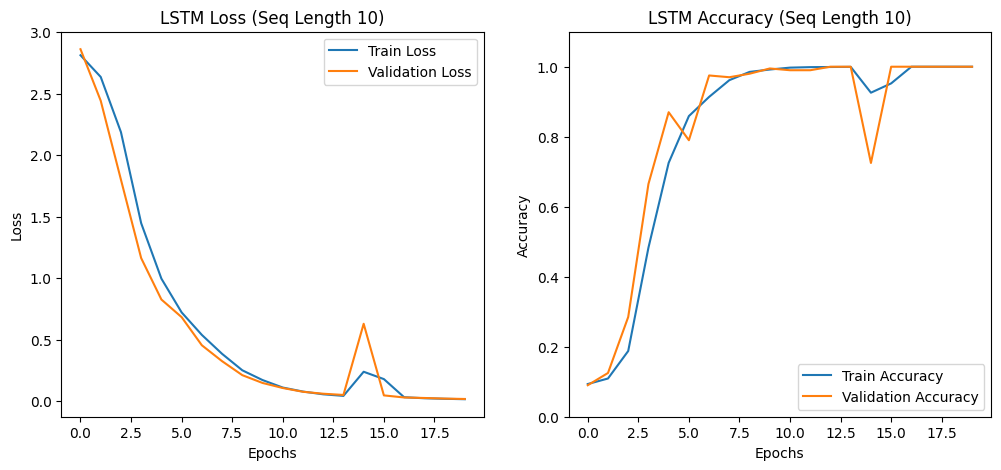

Training for sequence length: 30
Epoch 1/20, Train Loss: 2.7214, Val Loss: 2.5328, Train Acc: 0.0860, Val Acc: 0.1250
Epoch 2/20, Train Loss: 2.4644, Val Loss: 2.4668, Train Acc: 0.1058, Val Acc: 0.1150
Epoch 3/20, Train Loss: 2.4087, Val Loss: 2.4312, Train Acc: 0.1140, Val Acc: 0.1450
Epoch 4/20, Train Loss: 2.3881, Val Loss: 2.4181, Train Acc: 0.1266, Val Acc: 0.0900
Epoch 5/20, Train Loss: 2.3628, Val Loss: 2.4232, Train Acc: 0.1310, Val Acc: 0.1250
Epoch 6/20, Train Loss: 2.3542, Val Loss: 2.3795, Train Acc: 0.1306, Val Acc: 0.1200
Epoch 7/20, Train Loss: 2.3313, Val Loss: 2.3881, Train Acc: 0.1468, Val Acc: 0.1100
Epoch 8/20, Train Loss: 2.3218, Val Loss: 2.3912, Train Acc: 0.1440, Val Acc: 0.1150
Epoch 9/20, Train Loss: 2.3035, Val Loss: 2.3874, Train Acc: 0.1544, Val Acc: 0.1000
Epoch 10/20, Train Loss: 2.2802, Val Loss: 2.3987, Train Acc: 0.1654, Val Acc: 0.1300
Epoch 11/20, Train Loss: 2.2601, Val Loss: 2.3956, Train Acc: 0.1776, Val Acc: 0.1150
Epoch 12/20, Train Loss: 2.233

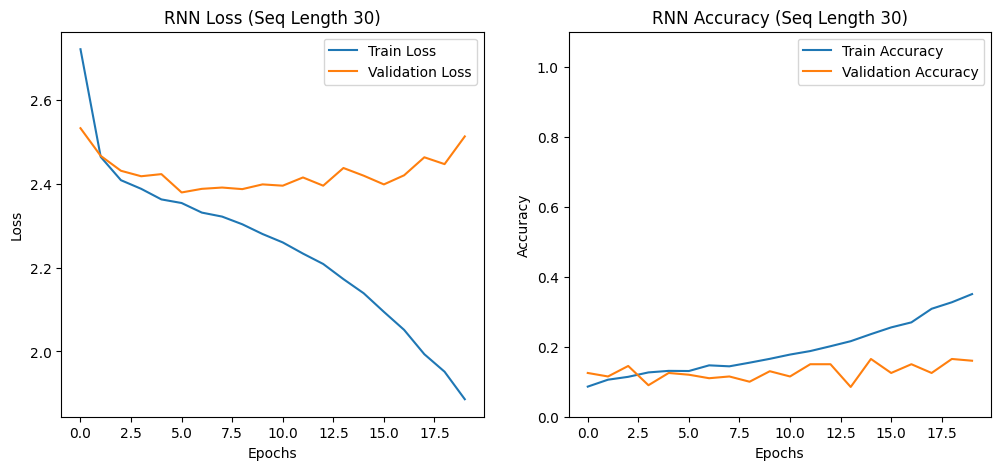

Epoch 1/20, Train Loss: 2.8077, Val Loss: 2.7484, Train Acc: 0.0858, Val Acc: 0.1150
Epoch 2/20, Train Loss: 2.6378, Val Loss: 2.4672, Train Acc: 0.0970, Val Acc: 0.1000
Epoch 3/20, Train Loss: 2.4582, Val Loss: 2.4477, Train Acc: 0.1098, Val Acc: 0.1000
Epoch 4/20, Train Loss: 2.4203, Val Loss: 2.4025, Train Acc: 0.1132, Val Acc: 0.1350
Epoch 5/20, Train Loss: 2.3867, Val Loss: 2.3470, Train Acc: 0.1188, Val Acc: 0.2050
Epoch 6/20, Train Loss: 1.9865, Val Loss: 1.7990, Train Acc: 0.2346, Val Acc: 0.2200
Epoch 7/20, Train Loss: 1.4167, Val Loss: 1.2347, Train Acc: 0.4554, Val Acc: 0.5800
Epoch 8/20, Train Loss: 1.0568, Val Loss: 0.9787, Train Acc: 0.6944, Val Acc: 0.7500
Epoch 9/20, Train Loss: 0.7971, Val Loss: 0.6762, Train Acc: 0.8556, Val Acc: 0.9650
Epoch 10/20, Train Loss: 0.6061, Val Loss: 0.5364, Train Acc: 0.9224, Val Acc: 0.9500
Epoch 11/20, Train Loss: 0.4546, Val Loss: 0.3652, Train Acc: 0.9602, Val Acc: 0.9900
Epoch 12/20, Train Loss: 0.2958, Val Loss: 0.2559, Train Acc: 0

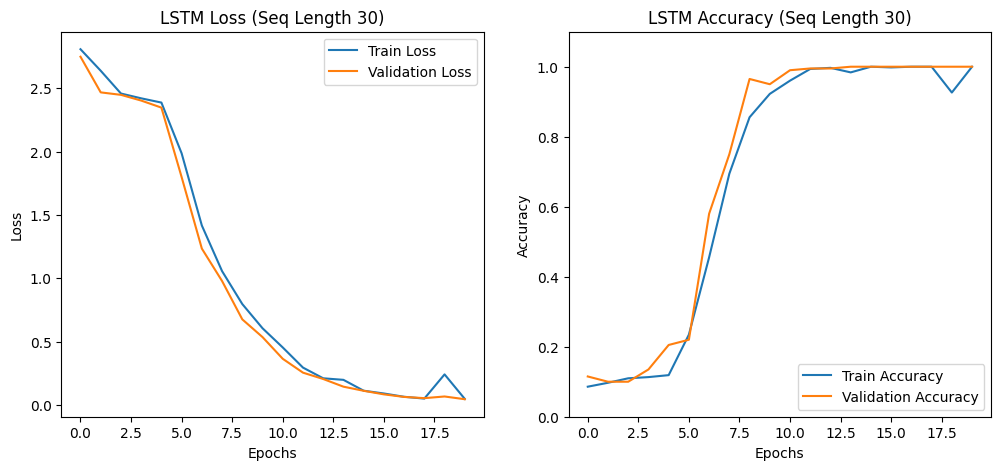

In [109]:
# Function to plot results
def plot_results(train_losses, val_losses, train_accs, val_accs, seq_length, model_type):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_type} Loss (Seq Length {seq_length})')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.1)
    plt.title(f'{model_type} Accuracy (Seq Length {seq_length})')
    plt.legend()
    
    plt.show()

# Running experiments for sequence lengths [5, 10, 30]
seq_lengths = [5, 10, 30]
num_epochs = 20
batch_size = 32

for seq_length in seq_lengths:
    print(f"Training for sequence length: {seq_length}")
    
    # Create dataset
    train_dataset = Add2DigitsDataset(num_examples=5000, seq_length=seq_length)
    val_dataset = Add2DigitsDataset(num_examples=200, seq_length=seq_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Train RNN
    rnn_model = MyRNN(input_size=11, hidden_size=128, output_size=19, num_layers=2, use_LSTM=False)
    train_losses, val_losses, train_accs, val_accs = train_model(rnn_model, train_loader, val_loader, num_epochs)
    plot_results(train_losses, val_losses, train_accs, val_accs, seq_length, "RNN")
    
    # Train LSTM
    lstm_model = MyRNN(input_size=11, hidden_size=128, output_size=19, num_layers=2, use_LSTM=True)
    train_losses, val_losses, train_accs, val_accs = train_model(lstm_model, train_loader, val_loader, num_epochs)
    plot_results(train_losses, val_losses, train_accs, val_accs, seq_length, "LSTM")


### __2.3__ Analysis (one point)

__Provide your analysis of the above experiment. Was the hypothesis from question 2.1 supported by your data? Why or why not? What might be the limitations of your experiment?__

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR ANALYSIS HERE)</div>
</center>


- Looking at the results, I would say that the hypothesis from Q2.1 is supported. (I used num_examples = 5000 for training and num_examples = 200 for validation.)
- For a sequence of length 5, both RNN and LSTM perform relatively well. For a sequence of length 10, both models can still learn the pattern effectively, although LSTM appears to learn slightly faster than RNN. For a sequence of length 30, RNN fails to learn, with validation accuracy consistently below 0.2. However, LSTM still performs well, learning the pattern quickly and achieving high accuracy (>0.95 on the validation set).
- This confirms the hypothesis that RNNs struggle to maintain information over longer sequences.

## <a name="3">Question 3: Short Response (2 points total)</a>

### __3.1__ What is an LSTM, anyhow? (one point)
__Describe, in your own words, the differences between an LSTM, and a simple RNN. Illustrate your answer visually with a diagram or diagrams. Also feel free to use math, as long as your terms are defined. It is OK to use existing images if you cite them and describe them in your own words.__

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR ANSWER HERE)</div>
</center>

***Key Difference***
- An RNN has a single hidden state that updates at each time step using the current input and the previous hidden state. However, it has vanishing (or exploding) gradients problem, making it hard to remember information over long sequences.
- LSTM solves this by using ***gates (input, forget, and output)*** to control what information is kept or forgotten, helping it retain important details.
- In short, LSTM is a type of RNN designed to handle long sequences better (by managing dependencies using gates).

***Math formulation***
- Simple RNN updates a hidden states $h_t=\tanh \left(W_h h_{t-1}+W_x x_t+b\right)$, where $x_t$ is the input at time $t_t$ and $W_h, W_x, b$ are learned parameters.
- LSTM has the following gates and states:
    - Forget Gate: $f_t=\sigma\left(W_f\left[h_{t-1}, x_t\right]+b_f\right)$. If $f_t \approx 1$, it means keeping most information; if $f_t \approx 0$, it means maximum forgetting.
    - Input Gate: $i_t=\sigma\left(W_i\left[h_{t-1}, x_t\right]+b_i\right)$. It controls how much new information should be added.
    - Candidate Cell State: $\tilde{C}_t=\tanh \left(W_c\left[h_{t-1}, x_t\right]+b_c\right)$. It creates candidate values for updating cell states.
    - New Cell State: $C_t=f_t \odot C_{t-1}+i_t \odot \tilde{C}_t$. The new cell state is a combination of the previous state and the candidate update.
    - Output Gate: $o_t=\sigma\left(W_o\left[h_{t-1}, x_t\right]+b_o\right)$ and finally $h_t=o_t \tanh \left(C_t\right)$. The hidden state $h_t$ is controlled by the output gate.





### __3.2__ GRUs vs LSTMs (one point)
Gated recurrent units (GRUs) and long short-term memory (LSTMs) are both types of recurrent neural networks (RNNs) that use gating mechanisms to control memory. Go out on the web and do some research and then do the following. 

__Describe, in your own words, the difference between a GRU and an LSTM. Give an example of a problem or a situation where you would be better off using a GRU and one where you would be better off using an LSTM. Explain your reasoning. Cite and quote a passage in the relevant article(s) that back up your assertion.__

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR ANSWER HERE)</div>
</center>

***Architectural Differences***
- LSTM: An LSTM unit has three gates: input, forget, and output. It also has a cell state that serves as memory, meaning it uses four sets of weights (for the input, forget, output, and cell gates).
- Since an LSTM has three gates (input, forget, and output) and a cell state, it requires four sets of weights (for the input, forget, output, and cell gates). The total number of parameters for an LSTM is given by: $4 \times(x \times h+h \times h+h)$, where $x$ is the input size and $h$ is the hidden state size.

- A GRU is a simplified version of an LSTM. It merges the cell state and hidden state and uses two gates: reset and update. Since a GRU has only two gates and no separate cell state, it requires three sets of weights (for the reset, update, and candidate activation).
- The total parameters for GRU would be $3 \times(x \times h+h \times h+h)$.
- Since an LSTM has more parameters, it may take longer to train. However, it is more flexible in learning long-term dependencies.

***LSTM vs GRU***
- From the paper "A Comparison of LSTM and GRU Networks for Learning Symbolic Sequences" by Roberto Cahuantzi, Xinye Chen, and Stefan Güttel, the authors found that "on high-complexity sequences, LSTMs perform better," while "GRUs outperform LSTM networks on low-complexity sequences."
- I guess for longer sequence tasks, such as language translation, which require maintaining context over a long sequence, LSTMs will do a better job. On the other hand, since GRUs are more computationally efficient, tasks such as real-time speech recognition (e.g., Siri, Alexa) could benefit because GRUs process input faster and with lower memory overhead ("Speech Recognition Application Using Deep Learning Neural Network" by Akzharkyn Izbassarova, Aziza Duisembay, and Alex Pappachen James).



## <a name="4">Question 4: Short Response (2 points total)</a>

### __4.1__ State Initialization (one point)

Assume we are given the task from [notebook 8](https://github.com/interactiveaudiolab/course-deep-learning/blob/main/notebooks/notebook_8_rnn.ipynb), in which we must predict the language from which a given name originates. Assume we are training an RNN in "cell" configuration, meaning we must manually handle the propagation of states, and that we pass our network one training example at a time. Finally, recall that in notebook 8, we demonstrate how to re-initialize the RNN cell's hidden state with a zero vector.

__What kind of information does the RNN cell's hidden state hold _after_ processing a full name input (but before re-initializing)?__

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR ANSWER HERE)</div>
</center>

- After processing a full name input (but before re-initializing), the ***RNN cell's hidden state*** will hold a representation (encoding) of the name that captures information about the sequence of characters seen so far. 
- Since the RNN processes the name character-by-character, the hidden state will contain both local and long-range dependencies of that name.

__Assume that we do not re-initialize the RNN cell's hidden state after processing a name input. What does this mean for the hidden state when we start processing the next name input?__

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR ANSWER HERE)</div>
</center>

- If we don't reinitialize the RNN cell's hidden state after processing a name, the hidden state at the start of the next name will contain information from the previous name.
- This will cause:
    - The hidden states to retain memory from the previous name, which can lead to incorrect learning since each name should be trained independently.
    - For example, the Russian name "Ivan" may carry over to the next name, say, "Pierre," which is French. (i.e., it contains information that biases the prediction toward Russian.)
    - This way, the model might incorrectly classify "Pierre" as Russian due to the residual memory from not reinitializing.
    - Also, without reinitializing, the model will treat the names as if they are connected in sequence, even though they should each be independent.


__Based on your answers above, when does it make most sense to re-initialize the hidden state for our task?__

1. __Only once, at the beginning of training__
2. __After processing each individual name input__
3. __After processing each epoch (i.e. after iterating over all names once)__

__Include a brief explanation supporting your answer.__

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR ANSWER HERE)</div>
</center>

- I think it should be: ***After processing each individual name input***.
- Because our task is to classify the origin of each name, each name should be treated independently.
- If we don’t reset the hidden state before processing a new name, the previous name's influence will carry over through the hidden states, biasing the prediction.

### __4.2__ Network Size (one point)

Assume we are given a simplified version of our task from [notebook 8](), in which we must predict the language from which a given name originates. In this simplified task, names are at most 10 characters long, and characters are drawn only from the standard english alphabet (26 possibilities). Names are drawn from the same 18 languages. Assume all inputs are one-hot encoded.

We consider two different network architectures:

* Network A pads all inputs to the maximum sequence length, flattens them, and passes them through two fully connected layers with sizes 256 and 18, respectively.
* Network B is a recurrent neural network identical to `RNNCell` in notebook 8, with hidden size 256 and output size 18.

__How many parameters does each network contain? Explain your reasoning.__

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR ANSWER HERE)</div>
</center>

- Network A:
    - First layer:
        - Input:  26 * 10 = 260
        - Hidden nodes: 256
        - Total parameters (weights + bias): 260 * 256 + 256 = 256 * (260 + 1) = 66816
    - Second layer:
        - Input: 256
        - Hidden nodes: 18
        - Total parameters (weights + bias): 256 * 18 + 18 = 18 * (256 + 1) = 4626
    - Total = 66816 + 4626 = 71442

- Network B:
    - First layer:
        - Input:  26 (character by chacter)
        - Hidden nodes: 256
        - Total parameters (weights + bias): 26 * 256 + 256 = 256 * (26 + 1) = 6912
    - Hidden to Hidden:
        - Input: 256
        - Hidden nodes: 256
        - Total parameters (weights + bias): 256 * 256 + 256 = 256 * (256 + 1) = 65792
    - Output:
        - 256 * 18 + 18 = 4626
    - Total = 6912 + 65792 + 4626  = 77330


__What if the maximum input length is 20 characters? What does your answer say about the sizes of fully-connected and recurrent networks as the sequence length grows?__

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR ANSWER HERE)</div>
</center>

- Network A:
    - First layer:
        - Input:  26 * 20 = 520
        - Hidden nodes: 256
        - Total parameters (weights + bias): 520 * 256 + 256 = 256 * (520 + 1) = 133376
    - Second layer:
        - Input: 256
        - Hidden nodes: 18
        - Total parameters (weights + bias): 256 * 18 + 18 = 18 * (256 + 1) = 4626
    - Total = 133376 + 4626 = 138002

- Network B:
    - First layer:
        - Input:  26 (character by chacter)
        - Hidden nodes: 256
        - Total parameters (weights + bias): 26 * 256 + 256 = 256 * (26 + 1) = 6912
    - Hidden to Hidden:
        - Input: 256
        - Hidden nodes: 256
        - Total parameters (weights + bias): 256 * 256 + 256 = 256 * (256 + 1) = 65792
    - Output:
        - 256 * 18 + 18 = 4626
    - Total = 6912 + 65792 + 4626  = 77330

- Network (Fully connected networks) grows linearly with the input length.
- Network B (RNN) should remain the same since RNN process the inputs sequentially (one character at a time) and updates the hidden state at each time step.

## <a name="5">Question 5: Reinforcement Learning (4 points total)</a>

### __5.1__ "Deep Reinforcement Learning: Pong from Pixels" (one point)


In his blog post ["Deep Reinforcement Learning: Pong from Pixels,"](http://karpathy.github.io/2016/05/31/rl/)  Andrej Karpathy explains how to use Deep Reinforcement Learning (RL) to train an agent to play the game of Pong using only raw pixel input. The post provides an introduction to key concepts and techniques in RL, such as policy gradients, stochastic policies, and reward discounting. Karpathy also discusses the limitations of the policy gradient approach compared to human learning and how policy gradients can be used to train neural networks with non-differentiable components.

Please answer the following questions based on the blog post:

1. What are some limitations of the policy gradient approach compared to how humans learn? (0.5 points)
2. How can policy gradients be used to train neural networks with non-differentiable components? (0.5 points)

**YOUR ANSWER GOES HERE**

1. What are some limitations of the policy gradient approach compared to how humans learn?
    - Unlike RL agents, which must discover the reward function through trial and error, humans typically receive clear instructions about what to do in a task (e.g., "Move the paddle to hit the ball in Pong").
    - Humans have prior knowledge, such as intuitive physics (e.g., the ball maintains velocity, won’t teleport) and psychology (e.g., the opponent is trying to win). RL agents lack this and must learn everything from scratch.
    - Policy gradient methods require vast amounts of training and trial-and-error exploration, whereas humans can learn effectively from just a few examples.
2. How can policy gradients be used to train neural networks with non-differentiable components? (0.5 points)
    - Policy gradients allow neural networks to work on non-differentiable components through ***treating them as stochastic policies***--the network learns a probability distribution over possible actions and updates it based on observed rewards. 
    - Mathematically, it does (more or less) the log-derivative trick: $$\nabla_\theta J(\theta)=\mathbb{E}\left[\sum_t R_t \nabla_\theta \log \pi_\theta\left(a_t \mid s_t\right)\right].$$
    - If a action led to a good reward, increase the probability, and vice versa. 
    - The parameter $\theta$ are updated via gradient ascent using the policy gradient theorem, through the following:
        - Sample an action $a_t \sim \pi_\theta\left(a \mid s_t\right)$.
        - Observe the reward $R_t$ from the game.
        - Now, we can compute the policy using the policy gradient theorem formula.
        - $\theta$ is updated through $\theta \leftarrow \theta+\alpha R_t \nabla_\theta \log \pi_\theta\left(a_t \mid s_t\right)$, in which $\nabla_\theta \log \pi_\theta\left(a_t \mid s_t\right)$ points to the direction to increase or decrease the probability.

### __5.2__ Pong (one point)

The following provides a partially completed implementation for training an agent to play Pong in [Gymnasium](https://gymnasium.farama.org/index.html) using policy gradients, as described in Andrej Karpathy's blog post ["Deep Reinforcement Learning: Pong from Pixels"](http://karpathy.github.io/2016/05/31/rl/).
Your task is to complete the code. The following steps are missing:

* Implement the policy gradient backward pass in the policy_backward function.

* In the main training loop, modulate the gradient with the advantage and accumulate the gradients over the batch.

* Also in the main training loop, perform the parameter update based on the accumulated gradients every batch_size episodes.

What you need to do this can be found in the blog post. The places in the code that you need to implement something are indicated by "YOUR CODE STARTS HERE"

Some tips:

* Make sure to follow the PyTorch conventions for computing gradients and updating parameters
* Print out the running reward periodically during training to monitor progress
* If training is slow on CPU, consider using Google Colab to train with GPU acceleration (using a T4 in Colab roughly triples the speed, compared to a CPU Colab instance)
* Although this code does checkpoint to disk, if you use Colab and your runtime is reset, you may lose the checkpoint. Consider mounting a Google Drive instance and saving the checkpoint to there.


In [3]:
#install libraries
!pip install torch numpy tqdm

# this is to install all the old atari games (including pong) from Gymnasium
!pip install gymnasium[atari,accept-rom-license]

# these are so we can render the video of the pong game
!pip install shimmy pyvirtualdisplay moviepy
!apt-get install -y xvfb ffmpeg

zsh:1: no matches found: gymnasium[atari,accept-rom-license]
  Obtaining dependency information for numpy>=1.18.0 from https://files.pythonhosted.org/packages/8d/29/076999b69bd9264b8df5e56f2be18da2de6b2a2d0e10737e5307592e01de/numpy-2.2.3-cp311-cp311-macosx_14_0_arm64.whl.metadata
  Using cached numpy-2.2.3-cp311-cp311-macosx_14_0_arm64.whl.metadata (62 kB)
Using cached numpy-2.2.3-cp311-cp311-macosx_14_0_arm64.whl (5.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 2

The following code shows Gymnasium in action. It generates a video of a pong game where our player acts randomly to move the paddle up and down. Look in your directory for the movie produced. If you're in Colab, look in the "video" directory and download the video you find there to view it. VLC will let you view it on PC. (VLC is a free and open-source video player. You can download it from this link: https://www.videolan.org/.) You can just click on it if you're on a Mac.

In [ ]:
import gym
print(gym.envs.registry.keys())  # Look for "ALE/Pong-v5"

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4'])


In [ ]:
import ale_py
from gym.envs.registration import register

# Manually register Pong
register(
    id="ALE/Pong-v5",
    entry_point="gym.envs.atari:AtariEnv",
    kwargs={"game": "pong", "obs_type": "rgb", "frameskip": 1},
    max_episode_steps=10000,
)

import gym
print(gym.envs.registry.keys())

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'ALE/Pong-v5'])


In [8]:
""" Example Gymnasium code to run pong with a randomly-acting player and save the
    output to an .mp4 file"""

import os
import torch
import numpy as np
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from pyvirtualdisplay import Display
import subprocess

import logging
logging.getLogger("gymnasium").setLevel(logging.ERROR)


display = Display(visible=0, size=(1400, 900))
display.start()

# Find the latest video increment
video_dir = "./video"
os.makedirs(video_dir, exist_ok=True)
video_files = [f for f in os.listdir(video_dir) if f.startswith("rl_video_random_agent_")]
# latest_increment = max([int(f.split("_")[-1].split(".")[0]) for f in video_files]) if video_files else 0

import re

# Extract numbers properly
increments = []
for f in video_files:
    match = re.search(r"rl_video_random_agent_(\d+)", f)
    if match:
        increments.append(int(match.group(1)))

latest_increment = max(increments) if increments else 0

# Create the environment with the latest video increment
env = gym.make("Pong-v4", render_mode="rgb_array")
env = RecordVideo(env, video_dir, episode_trigger=lambda x: True, name_prefix=f"rl_video_random_agent_{latest_increment+1}")
observation, info = env.reset()

while True:
    env.render()

    # get the action from the player. This is what we'll be replacing with the
    # output of our trained policy network.
    aprob = 0.5
    action = 2 if torch.rand(1) < aprob else 3  # roll the dice!

    # step the environment and get new measurements
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:  # an episode finished
        break

env.close()


A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/luhsin/Downloads/course-deep-learning/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


The following code is a lightly-altered version of Andrej Karpathy's original code. We've modified it to run properly in Gymnasium. Note that it hand-codes things we we would normally call as pytorch functions (e.g. ReLu and Sigmoid activations), so the network won't look like you're used to.  

Note: This code uses Gymnasium, but will NOT render a movie. You use this strictly for training. Once you've trained it and gotten a saved model in 'save.pt', go on to the next question, where there is code to run your saved model and render the output to a video.

Note: Actually, train it for a few episodes (not 8000 episodes, but rather, right after your first saved checkpoint) and then hit "break" and go try generating a video with the model that you've saved. That will get you 1/3 of the points on that problem and also ensure you understand the whole work flow.

In [ ]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal GPU on Apple Silicon
elif torch.cuda.is_available():
    device = torch.device("cuda")  # CUDA for NVIDIA GPUs (not on M2)
else:
    device = torch.device("cpu")   # Default to CPU

print(f"Using device: {device}")

Using device: mps


In [ ]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses Gymnasium. """
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
import tqdm
from tqdm.notebook import tqdm


# hyperparameters
H = 200  # number of hidden layer neurons
batch_size = 20  # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99  # discount factor for reward
decay_rate = 0.99  # decay factor for RMSProp leaky sum of grad^2
resume = True  # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80  # input dimensionality: 80x80 grid

# device = torch.device("cpu")
# Uncomment the following line if you decide to make a cuda implementation
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# This is where we load our model from a checkpoint...or else initialize from scratch.
# Note, if you don't have a 'save.pt' in your directory, you will get an error if you
# try and resume from it.  One more warning: In co-lab, when you reset your environment,
# you may lose your save.pt file. Consider saving to and reloading from
# google drive, so you don't lose intermediate work.
resume = os.path.exists('save.pt')  # Check if file exists

if resume:
    model = torch.load('save.pt')
else:
    model = {}
    model['W1'] = torch.randn(H, D, device=device) / np.sqrt(D)  # "Xavier" initialization
    model['W2'] = torch.randn(H, device=device) / np.sqrt(H)

grad_buffer = {k: torch.zeros_like(v, device=device) for k, v in model.items()}  # update buffers that add up gradients over a batch
rmsprop_cache = {k: torch.zeros_like(v, device=device) for k, v in model.items()}  # rmsprop memory

def sigmoid(x):
    return 1.0 / (1.0 + torch.exp(-x))  # sigmoid "squashing" function to interval [0,1]

def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195]  # crop
    I = I[::2, ::2, 0]  # downsample by factor of 2
    I[I == 144] = 0  # erase background (background type 1)
    I[I == 109] = 0  # erase background (background type 2)
    I[I != 0] = 1  # everything else (paddles, ball) just set to 1
    return torch.from_numpy(I.astype(np.float32).ravel()).to(device)

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = torch.zeros_like(r)
    running_add = 0
    for t in reversed(range(r.size(0))):
        if r[t] != 0:
            running_add = 0  # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def policy_forward(x):
    h = torch.matmul(model['W1'], x)
    h[h < 0] = 0  # ReLU nonlinearity
    logp = torch.matmul(model['W2'], h)
    p = sigmoid(logp)
    return p, h  # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
    """ backward pass. (eph is array of intermediate hidden states) """
    ###########################################################
    # YOUR CODE STARTS HERE (1/3)
    ###########################################################

    # Compute gradients
    dW2 = torch.matmul(epdlogp, eph)  # Compute gradient for W2
    dh = torch.matmul(epdlogp.unsqueeze(1), model['W2'].unsqueeze(0))  # Backprop through W2
    dh[eph <= 0] = 0  # Apply ReLU non-linearity

    # Compute gradient for W1 correctly using epx
    dW1 = torch.matmul(dh.T, epx)

    return {'W1': dW1, 'W2': dW2}

    ###########################################################
    # YOUR CODE ENDS HERE (1/3)
    ###########################################################

env = gym.make("Pong-v4")
observation, info = env.reset()
prev_x = None  # used in computing the difference frame
xs, hs, dlogps, drs = [], [], [], []
running_reward = None
reward_sum = 0
episode_number = 0

pbar = tqdm()
while True:
    if render:
        env.render()

    # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else torch.zeros(D, device=device)
    prev_x = cur_x

    # forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)
    action = 2 if torch.rand(1, device=device) < aprob else 3  # roll the dice! based on the probability output by the policy network

    # record various intermediates (needed later for backprop)
    xs.append(x)  # observation
    hs.append(h)  # hidden state
    y = 1 if action == 2 else 0  # a "fake label"
    dlogps.append(y - aprob)  # grad that encourages the action that was taken to be taken (see ;' if confused)

    # step the environment and get new measurements
    observation, reward, done, truncated, info = env.step(action)
    reward_sum += reward

    drs.append(reward)  # record reward (has to be done after we call step() to get reward for previous action)

    if done or truncated:  # an episode finished
        episode_number += 1
        pbar.update(episode_number)

        # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = torch.stack(xs)
        eph = torch.stack(hs)
        epdlogp = torch.stack(dlogps)
        epr = torch.tensor(drs, device=device)
        xs, hs, dlogps, drs = [], [], [], []  # reset array memory

        # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
        # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        # discounted_epr -= discounted_epr.mean()
        # discounted_epr /= discounted_epr.std()


        ###########################################################
        # YOUR CODE STARTS HERE (2/3)
        ###########################################################

        # modulate the gradient with advantage (PG magic happens right here.)
        # it might be good to do something with policy_backward
        # accumulate grad over batch
        # Standardize rewards more carefully to prevent instability
        discounted_epr -= discounted_epr.mean()
        discounted_epr /= (discounted_epr.std() + 1e-4)  # Prevents instability



        # Modulate the gradient with advantage (PG magic happens here)
        # epdlogp *= discounted_epr
        epdlogp = epdlogp * discounted_epr.detach()


        # Compute gradients
        grad = policy_backward(eph, epdlogp)

        # Accumulate gradients over the batch
        for k in model:
            grad_buffer[k] += grad[k]

        ###########################################################
        # YOUR CODE ENDS HERE (2/3)
        ###########################################################


        # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:

            ###########################################################
            # YOUR CODE STARTS HERE (3/3)
            ###########################################################
            # If it were me, I'd loop through k and v in the model items
            #   For every element k of grad_buffer, I'd get the gradient
            #   Then, for the kth rmsprop_cache element I'd do my update
            #   Then I'd update the model's kth item appropriately
            #   Then I'd reset the grad_buffer to zeros.
            # Look at the blog code for more....
            # Define Adam optimizer (only once)
            if 'optimizer' not in globals():
                optimizer = torch.optim.RMSprop([model['W1'], model['W2']], lr=1e-4, alpha=0.99)
                print("Switched to Adam optimizer dynamically.")

            optimizer.zero_grad()

            # Manually set gradients for model parameters
            for k in model:
                model[k].grad = grad_buffer[k] / batch_size  # Apply accumulated gradients

            torch.nn.utils.clip_grad_norm_([model['W1']], max_norm=0.1)
            torch.nn.utils.clip_grad_norm_([model['W2']], max_norm=0.05)


            optimizer.step()  # Perform Adam optimization step

            # Reset gradient buffer
            for k in grad_buffer:
                grad_buffer[k] = torch.zeros_like(model[k])

            # Save model checkpoint
            torch.save(model, 'save.pt')

            # Log useful information
            running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
            print(f'Model saved. resetting environment. episode reward total: {reward_sum:.2f}. Running mean: {running_reward:.2f}')

            # Debugging: Check gradient norms
            print(f"Grad Norm W1: {torch.norm(grad['W1']).item():.6f}, W2: {torch.norm(grad['W2']).item():.6f}")

            ###########################################################
            # YOUR CODE ENDS HERE (3/3)
            ###########################################################

        # checkpoints are saved every 100 episodes
        if episode_number % 100 == 0:
            torch.save(model, 'save.pt')
            # boring book-keeping
            running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
            print(f'Model saved. resetting environment. episode reward total: {reward_sum:.2f}. Running mean: {running_reward:.2f}')

        reward_sum = 0
        observation, info = env.reset()  # reset env
        prev_x = None

    if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
        pbar.set_description(f'episode {episode_number}: game finished, reward: {reward}' + ('' if reward == -1 else ' !!!!!!!!'))



/var/folders/k0/fvwqq5_j5rnbtd9vybfq4xgr0000gn/T/ipykernel_59056/1286651001.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('save.pt')


0it [00:00, ?it/s]

Model saved. resetting environment. episode reward total: -16.00. Running mean: -16.00
Grad Norm W1: 181.395935, W2: 37.780624
Model saved. resetting environment. episode reward total: -15.00. Running mean: -15.99
Grad Norm W1: 157.638977, W2: 34.179146
Model saved. resetting environment. episode reward total: -14.00. Running mean: -15.97
Grad Norm W1: 145.256958, W2: 21.412045
Model saved. resetting environment. episode reward total: -16.00. Running mean: -15.97
Grad Norm W1: 168.567657, W2: 37.352989
Model saved. resetting environment. episode reward total: -16.00. Running mean: -15.97
Grad Norm W1: 143.158112, W2: 25.937000
Model saved. resetting environment. episode reward total: -16.00. Running mean: -15.97
Model saved. resetting environment. episode reward total: -17.00. Running mean: -15.98
Grad Norm W1: 168.225159, W2: 29.465641
Model saved. resetting environment. episode reward total: -19.00. Running mean: -16.01
Grad Norm W1: 134.431000, W2: 29.500406
Model saved. resetting e

KeyboardInterrupt: 

### __5.3__ Running Pong (one point)

Create 3 videos using the following code:

* A video of the agent playing pong after 100 eposodes of training
* A video of the agent playing pong after 8000 episodes of training
* A video of the agent playing after however many episodes it takes you to do about as well as [Karpathy's example video](https://www.youtube.com/watch?v=YOW8m2YGtRg&list=TLGG2Hi1VyMnZ7gxNzA1MjAyNA) of his agent (which supposedly took 8000 episodes to train).

NOTE: The code will run the model in 'save.pt' found in the current directory.

NOTE: If there is already a video in the directory with the same name, this code breaks. So, to make a 2nd video...either move your previous video elsewhere or modify the code.



**YOUR ANSWER GOES HERE**
<center>
<div style="color:red;background-color:#e5e5e5">(YOUR 100 EPISODE VIDEO GOES HERE)</div>
</center>

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR 8000 EPISODE VIDEO GOES HERE)</div>
</center>

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR MAX EPISODE VIDEO GOES HERE. BE SURE TO LABEL THIS WITH HOW MANY EPISODES IT TOOK)</div>
</center>


***1000 Episode Video Link***

https://youtube.com/shorts/6j9Xi1KJxzA?feature=share

***8000 Episode Video Link***

https://youtube.com/shorts/ebClRDfXUmE?feature=share

***10,000 Epsisode Video Link***

https://youtube.com/shorts/MaX1JN0DCFY?feature=share

I stopped at around 10,000 episodes (taking two days on my local computer). From the reward total I printed, it's not improving that much. Not sure if there is something wrong with the parameter updates or if it's just taking super long to train. My ageint is constantly able to win like 5 points all throughout. I had some issues setting up Colab, so I ran the whole thing on my computer. It's using up all my computer memory... so I had to stop... sorry...

In [ ]:
import os

roms_path = os.path.expanduser("~/.ale/roms/")
if os.path.exists(roms_path):
    print("Atari ROMs are installed in:", roms_path)
    print("List of ROM files:", os.listdir(roms_path))
else:
    print("Atari ROMs are STILL missing.")


In [ ]:
import os

roms_path = os.path.expanduser("~/.ale/roms/")
print("List of ROM files:", os.listdir(roms_path))


In [ ]:
import gymnasium as gym
print("Installed environments:", gym.envs.registry.keys())


In [ ]:
""" Useful Script to help record videos of your model playing Pong. REMEMBER TO USE VLC WHEN WATCHING!!!!!!"""

import os
import torch
import numpy as np
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from pyvirtualdisplay import Display
import subprocess

import logging
logging.getLogger("gymnasium").setLevel(logging.ERROR)


# hyperparameters
D = 80 * 80  # input dimensionality: 80x80 grid
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the trained model
model = torch.load('/Users/luhsin/Downloads/course-deep-learning/save.pt', map_location=device)

# If model is a full model (not a state_dict), extract the state_dict
if isinstance(model, torch.nn.Module):
    model = model.state_dict()

# Move model parameters to the correct device
for key in model:
    model[key] = model[key].to(device)


def sigmoid(x):
    return 1.0 / (1.0 + torch.exp(-x))  # sigmoid "squashing" function to interval [0,1]

def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195]  # crop
    I = I[::2, ::2, 0]  # downsample by factor of 2
    I[I == 144] = 0  # erase background (background type 1)
    I[I == 109] = 0  # erase background (background type 2)
    I[I != 0] = 1  # everything else (paddles, ball) just set to 1
    return torch.from_numpy(I.astype(np.float32).ravel()).to(device)

# def policy_forward(x):
#     h = torch.matmul(model['W1'], x)
#     h[h < 0] = 0  # ReLU nonlinearity
#     logp = torch.matmul(model['W2'], h)
#     p = sigmoid(logp)
#     return p, h  # return probability of taking action 2, and hidden state
def policy_forward(x):
    x = x.view(-1).to(device)  # Ensures x is a 1D tensor
    print(f"x shape after reshaping: {x.shape}, x device: {x.device}")  
    print(f"W1 shape: {model['W1'].shape}, W1 device: {model['W1'].device}")  

    h = torch.matmul(model['W1'], x)  # (200, 6400) @ (6400,) -> (200,)
    h = torch.relu(h)  # Apply ReLU explicitly
    logp = torch.matmul(model['W2'], h)  # (1, 200) @ (200,) -> (1,)
    p = sigmoid(logp)

    return p, h  # Probability of action and hidden state



# Find the latest video increment
video_dir = "./video"
os.makedirs(video_dir, exist_ok=True)
video_files = [f for f in os.listdir(video_dir) if f.startswith("rl_video_trained_model_")]
import re

# Extract only the numerical part at the end of the filename before "-episode"
increments = [int(re.search(r"(\d+)-episode", f).group(1)) for f in video_files if re.search(r"(\d+)-episode", f)]

latest_increment = max(increments) if increments else 0


# Create the environment with the latest video increment
env = gym.make("ALE/Pong-v5", render_mode="rgb_array")
env = RecordVideo(env, video_dir, name_prefix=f"rl_video_trained_model_{latest_increment+1}", episode_trigger=lambda x: True)
observation, info = env.reset()
prev_x = None  # used in computing the difference frame

while True:
    env.render()

    # Process observation
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else torch.zeros(D, device=device)
    prev_x = cur_x

    # Forward pass & action selection
    aprob, h = policy_forward(x)
    action = 2 if torch.rand(1, device=device) < aprob else 3

    # Step environment
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        print(f"Finished Recording Episode {episode + 1}")
        break

env.close()


In [ ]:
""" Useful Script to help record videos of your model playing Pong. REMEMBER TO USE VLC WHEN WATCHING!!!!!!"""

import os
import torch
import numpy as np
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import re
import logging

logging.getLogger("gymnasium").setLevel(logging.ERROR)

# Hyperparameters
D = 80 * 80  # input dimensionality: 80x80 grid
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = torch.load('/Users/luhsin/Downloads/course-deep-learning/save.pt', map_location=device)

# If model is a full model (not a state_dict), extract the state_dict
if isinstance(model, torch.nn.Module):
    model = model.state_dict()

# Move model parameters to the correct device
for key in model:
    model[key] = model[key].to(device)

def sigmoid(x):
    return 1.0 / (1.0 + torch.exp(-x))  # sigmoid function to map to [0,1]

def prepro(I):
    """Preprocess 210x160x3 uint8 frame into 6400 (80x80) 1D float vector."""
    I = I[35:195]  # crop
    I = I[::2, ::2, 0]  # downsample by factor of 2
    I[I == 144] = 0  # erase background (background type 1)
    I[I == 109] = 0  # erase background (background type 2)
    I[I != 0] = 1  # everything else (paddles, ball) just set to 1
    return torch.from_numpy(I.astype(np.float32).ravel()).to(device)

def policy_forward(x):
    x = x.view(-1).to(device)  # Ensures x is a 1D tensor
    h = torch.matmul(model['W1'], x)  # (200, 6400) @ (6400,) -> (200,)
    h = torch.relu(h)  # Apply ReLU explicitly
    logp = torch.matmul(model['W2'], h)  # (1, 200) @ (200,) -> (1,)
    p = sigmoid(logp)

    return p, h  # Probability of action and hidden state

# Set which episodes to record
record_episodes = {100, 1000, 8000, 1000} 

for episode in record_episodes:
    print(f"Recording Episode {episode}...")

    # Set up separate video directories for each milestone
    video_dir = f"./video/episode_{episode}"
    os.makedirs(video_dir, exist_ok=True)

    # Create the environment
    env = gym.make("ALE/Pong-v5", render_mode="rgb_array")
    env = RecordVideo(env, video_dir, 
                      name_prefix=f"rl_video_trained_model_{episode}",
                      episode_trigger=lambda x: True)

    # Play one episode with the trained model
    observation, info = env.reset()
    prev_x = None  # Reset previous frame

    while True:
        env.render()
        
        # Process observation
        cur_x = prepro(observation)
        x = cur_x - prev_x if prev_x is not None else torch.zeros(D, device=device)
        prev_x = cur_x

        # Forward pass & action selection
        aprob, h = policy_forward(x)
        action = 2 if torch.rand(1, device=device) < aprob else 3  # Sample action

        # Step environment
        observation, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
            print(f"Finished Recording Episode {episode}")
            break

    env.close()

print("All specified episodes recorded.")


### __5.4__ Understanding Deep Reinforcement Learning (one point)
Consider this code block from the main training loop for reinforcement learning in the provided code:
```
    # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else torch.zeros(D, device=device)
    prev_x = cur_x
```
1. Explain the point of the preprocessing done in the function called in the first line.
1. Explain the point of subtraction of the previous frame from the current frame shown in the second line of the code. Why not just look at the current observation?



**YOUR ANSWER GOES HERE**
- The function ```prepro(observation)``` reduces the complexity of the raw game frames. Specifically, it does the following:
    - Cropping
    - Downsampling by 2, ```I = I[::2, ::2, 0]  # downsample by factor of 2``` reduces the resolution from 210x160 pixels to 80x80.
    - Remove backgroud, ```144``` and ```109``` are two different shades of gray, setting them 0 means removing background.
    - Convert everything else (paddles and ball) to 1 
    - In sum, it converts the 210x160x3 colored image into a binary 80 × 80 grid, facilitating the training process.
- The subtraction ```x = cur_x - prev_x if prev_x is not None else torch.zeros(D, device=device)``` computes the difference between two frames.
    - By taking the subtraction, only the moving objects remain (i.e., the paddles and the ball).
    - If we look only at the current observation, we don’t know the direction or the speed at which the ball is moving.
    - Also, the machine can see how its action affect the paddle movement.



